<a href="https://colab.research.google.com/github/seansothey/CSC685/blob/master/Cifar10_RF_vs_SVM_vs_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://aiinpractice.com/wp-content/uploads/2018/05/cifar10.jpg)

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

CIFAR-10 is a set of images that can be used to teach a computer how to recognize objects. Since the images in CIFAR-10 are low-resolution (32x32), this dataset can allow researchers to quickly try different algorithms to see what works. Various kinds of convolutional neural networks tend to be the best at recognizing the images in CIFAR-10.

https://en.wikipedia.org/wiki/CIFAR-10

#Setup

In [0]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow import keras
import cv2
from google.colab.patches import cv2_imshow

import math
import os

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

#Explore the data

In [0]:
cifar10 = keras.datasets.cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [0]:
class_names = ['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

In [5]:
num_classes = len(np.unique(y_train))
num_classes

10

View some images from data

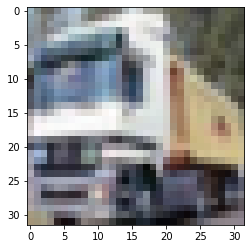

In [6]:
#View image #1
plt.figure()
plt.imshow(X_train[1])
plt.grid(False)

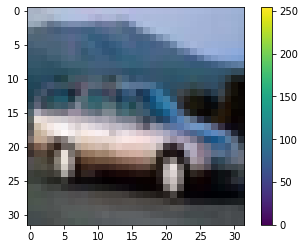

In [7]:
#View image #4
plt.figure()
plt.imshow(X_train[4])
plt.colorbar()
plt.grid(False)

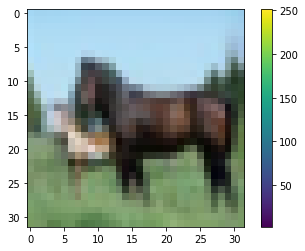

In [8]:
#View image #12
plt.figure()
plt.imshow(X_train[12])
plt.colorbar()
plt.grid(False)

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

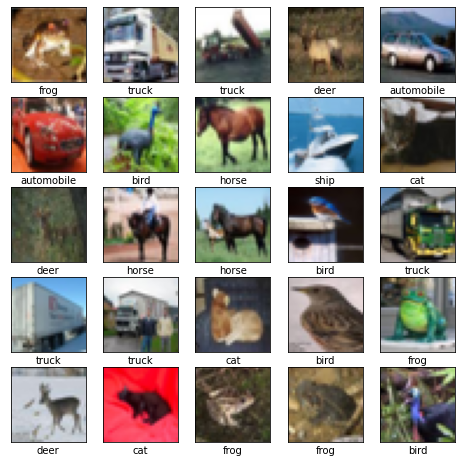

In [9]:
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i][0]])

Scale dataset to 0-1

In [10]:
np.amax(X_train), np.amax(X_test) # see the max value before scale

(255, 255)

In [0]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

Reshape dataset

In [0]:
nsamples, nx, ny, nz = X_train.shape
X_train_2d = X_train.reshape((nsamples,nx*ny*nz))

nsamples, nx, ny, nz = X_test.shape
X_test_2d = X_test.reshape((nsamples,nx*ny*nz))

nsamples, nx = y_train.shape
y_train = y_train.reshape(nsamples)

nsamples, nx = y_test.shape
y_test = y_test.reshape(nsamples)

In [13]:
X_train_2d.shape, X_test_2d.shape

((50000, 3072), (10000, 3072))

#Apply PCA

In [0]:
from sklearn.decomposition import PCA

pca = PCA(0.95) # use variation=95%
X_train_pca = pca.fit_transform(X_train_2d)
X_test_pca = pca.transform(X_test_2d)

In [15]:
X_train_pca.shape, X_test_pca.shape

((50000, 217), (10000, 217))

Now, new dataset has been reduced from (50000, 3072) to (50000, 217)

# Plot to see dataset behavior

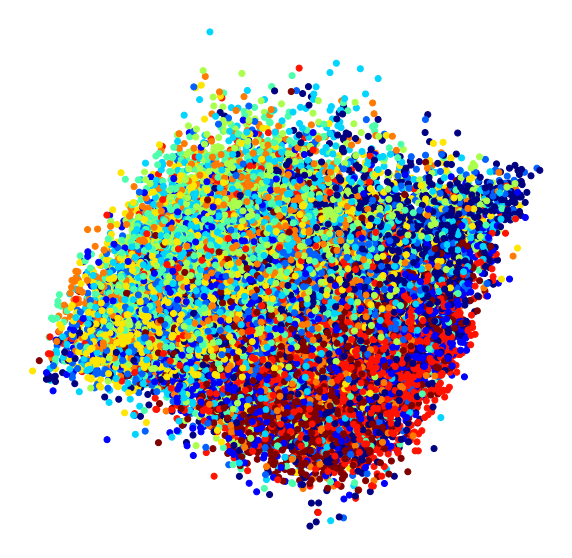

In [17]:
plt.figure(figsize=(10,10))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap="jet")
plt.axis('off')
plt.show()

#Multiclass classification RandomForest

In [18]:
# Create the learning model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_pca, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
# Use the model to predict on testing dataset
y_pred_rf = rf.predict(X_test_pca)

In [20]:
#See the accuracy on testing 
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred_rf)

0.4365

Let's see the prediction for the first 25 images (incorrect labels in red)

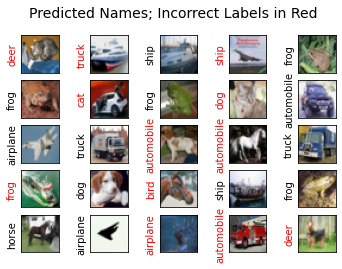

In [22]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i], cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(class_names[y_pred_rf[i]].split()[-1],
                   color='black' if y_pred_rf[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

This can be seen that the number of correct prediction is about 45% rate as expected.

#Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

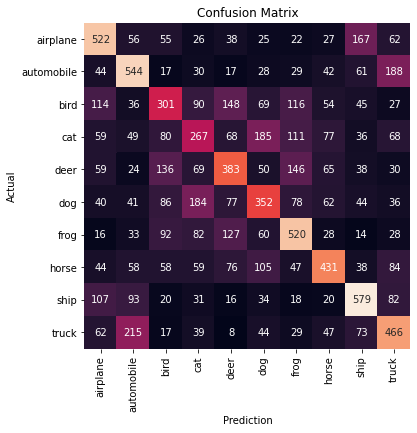

In [24]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(6,6)) 
mat = confusion_matrix(y_pred_rf, y_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

#Sensitivity, Specificity and F1-Score 

In [25]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_rf,target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.49      0.52      0.51      1000
  automobile       0.47      0.54      0.51      1000
        bird       0.35      0.30      0.32      1000
         cat       0.30      0.27      0.28      1000
        deer       0.40      0.38      0.39      1000
         dog       0.37      0.35      0.36      1000
        frog       0.47      0.52      0.49      1000
       horse       0.51      0.43      0.47      1000
        ship       0.53      0.58      0.55      1000
       truck       0.44      0.47      0.45      1000

    accuracy                           0.44     10000
   macro avg       0.43      0.44      0.43     10000
weighted avg       0.43      0.44      0.43     10000



#Multiclass classification SVM

In [26]:
# Create the learning model
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train_pca, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
# Use the model to predict on testing dataset
y_pred_svm = svm_clf.predict(X_test_pca)

In [28]:
#See the accuracy on testing 
accuracy_score(y_test, y_pred_svm)

0.5382

Let's see the prediction for the first 25 images (incorrect labels in red)

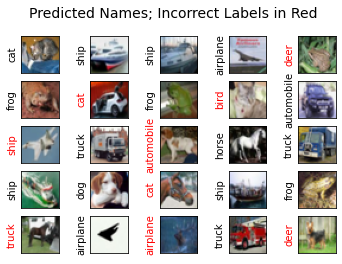

In [29]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i], cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(class_names[y_pred_svm[i]].split()[-1],
                   color='black' if y_pred_svm[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

This can be seen that the number of correct prediction is about 55% rate as expected.

#Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

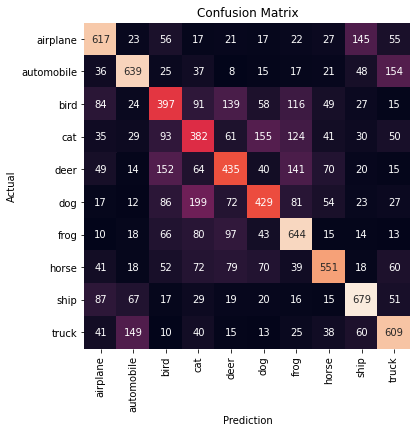

In [30]:
fig, ax = plt.subplots(figsize=(6,6)) 
mat_svm = confusion_matrix(y_pred_svm, y_test)
sns.heatmap(mat_svm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

#Sensitivity, Specificity and F1-Score 

In [32]:
from sklearn.metrics import classification_report
report_svm = classification_report(y_test, y_pred_svm,target_names=class_names)
print(report_svm)

              precision    recall  f1-score   support

    airplane       0.61      0.62      0.61      1000
  automobile       0.64      0.64      0.64      1000
        bird       0.42      0.40      0.41      1000
         cat       0.38      0.38      0.38      1000
        deer       0.46      0.43      0.45      1000
         dog       0.50      0.43      0.46      1000
        frog       0.53      0.64      0.58      1000
       horse       0.63      0.55      0.59      1000
        ship       0.64      0.68      0.66      1000
       truck       0.58      0.61      0.59      1000

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.54     10000
weighted avg       0.54      0.54      0.54     10000



#Multiclass classification CNN Model

In [72]:
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers, optimizers
np.random.seed(168)

print(tf.__version__)

2.2.0


In [0]:
# Instance 2 layers model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)),  # 1st layer
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(16, kernel_size=(3,3), activation='relu'), # 2nd layer
    MaxPooling2D(pool_size=(1, 1)),
    BatchNormalization(),

    Conv2D(16, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)), # 3rd layer
    BatchNormalization(),

    Conv2D(8, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)), # 4th layer
    BatchNormalization(),

    Dropout(0.1),
    Flatten(),
    Dense(300, activation='relu'),
    Dense(100, activation='relu'),
    Dense(10, activation='softmax')
])

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [110]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_65 (Batc (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 13, 13, 16)        4624      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 13, 13, 16)        64        
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 11, 11, 16)      

In [111]:
model.fit(X_train, y_train, batch_size=50, epochs=20, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 12s 305us/step - loss: 1.7156 - accuracy: 0.4441 - val_loss: 1.5110 - val_accuracy: 0.5012
Epoch 2/20
40000/40000 [==============================] - 11s 278us/step - loss: 1.3076 - accuracy: 0.5661 - val_loss: 1.4191 - val_accuracy: 0.5059
Epoch 3/20
40000/40000 [==============================] - 11s 279us/step - loss: 1.1283 - accuracy: 0.6197 - val_loss: 1.2179 - val_accuracy: 0.5839
Epoch 4/20
40000/40000 [==============================] - 11s 277us/step - loss: 1.0171 - accuracy: 0.6594 - val_loss: 1.1840 - val_accuracy: 0.6061
Epoch 5/20
40000/40000 [==============================] - 12s 297us/step - loss: 0.9291 - accuracy: 0.6860 - val_loss: 1.2238 - val_accuracy: 0.6120
Epoch 6/20
40000/40000 [==============================] - 11s 278us/step - loss: 0.8642 - accuracy: 0.7106 - val_loss: 1.0312 - val_accuracy: 0.6527
Epoch 7/20
40000/40000 [==============================] 

In [112]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.27011396484375
Test accuracy: 0.6816999912261963


#Conclusion

After many experiments, running all models on testing dataset, the CNN model is considered as the winner, with the highest accuracy **68%**. The RandomForest model produced the lowest accuracy **%44** with the fastest training time; constrastly, SVM model produced better accuracy **%54** with the longest training time (almost 2 hours).

To improve all models' performance accuracies, hyperparameters tuning technique, such as **GridSearchCV** for RandomForest and SVM model, and **RandomSearch** or **Hyperband** for CNN model, shall be used. 